In [1]:
import pandas as pd

/Users/abhishek/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:992: UserWarning: Illegal line #1
	"{\rtf1\ansi\ansicpg1252\cocoartf1504\cocoasubrtf830
"
	in file "/Users/abhishek/.matplotlib/matplotlibrc"
  warnings.warn('Illegal %s' % error_details)
/Users/abhishek/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:992: UserWarning: Illegal line #2
	"{\fonttbl\f0\fswiss\fcharset0 Helvetica;}
"
	in file "/Users/abhishek/.matplotlib/matplotlibrc"
  warnings.warn('Illegal %s' % error_details)
/Users/abhishek/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:992: UserWarning: Illegal line #3
	"{\colortbl;\red255\green255\blue255;}
"
	in file "/Users/abhishek/.matplotlib/matplotlibrc"
  warnings.warn('Illegal %s' % error_details)
/Users/abhishek/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:992: UserWarning: Illegal line #4
	"{\*\expandedcolortbl;;}
"
	in file "/Users/abhishek/.matplotlib/matplotlibrc"
  warnings.warn('Illegal %s' % error_d

In [2]:
cd LC_data/

/Users/abhishek/Desktop/gan_sdn/Gan_MTX/LC_data


In [3]:
data=pd.read_csv("Final_data_set_18_features.csv")
del data["Unnamed: 0"]
import matplotlib.pyplot as plt
d_1=data.loc[data['Response'] == 1]
d_1_sample=d_1.sample(5000)
data_new=d_1_sample

import numpy as np
def dictionary(val):
    number_of_categories=len(val.unique())
    if number_of_categories==2:
        ar=[0,1]
    else:
        ar=np.linspace(0,1,number_of_categories)
    categories=val.unique()
    dic= dict(zip(categories, ar))
    
    return(dic)

data_new['application_type'].replace(dictionary(data_new['application_type']), inplace=True)
data_new['sub_grade'].replace(dictionary(data_new['sub_grade']), inplace=True)
data_new['term'].replace(dictionary(data_new['term']), inplace=True)
data_new['emp_length'].replace(dictionary(data_new['emp_length']), inplace=True)
data_new['home_ownership'].replace(dictionary(data_new['home_ownership']), inplace=True)

data_cols = list(data_new.columns[ data_new.columns != 'Response' ])
label_cols = ['Response']
print(data_cols)
print('# of data columns: ',len(data_cols))

label_cols = ['Response']
data_cols = list(data_new.columns[ data_new.columns != 'Response' ])

#print(data_cols)
print('# of data columns: ',len(data_cols))

## removing the nan columns as they are continous variables with classes equal to 0 and 1
data_cols = list(set(data_cols) - set(['application_type','term','delinq_2yrs','home_ownership']))
                                       
print(data_cols)
print('# of data columns: ',len(data_cols))


percentiles =  pd.DataFrame( np.array([ np.percentile( data_new[i], [ 0.1, 99.9 ] ) for i in data_cols ]).T,
                            columns=data_cols, index=['min','max'] )

print(percentiles)
percentile_means = \
    [ [ np.mean( data_new.loc[ (data_new[i]>percentiles[i]['min']) & (data_new[i]<percentiles[i]['max']) , i ] ) ]
     for i in data_cols ]

percentiles = percentiles.append( pd.DataFrame(np.array(percentile_means).T, columns=data_cols, index=['mean']) )

percentile_stds = \
    [ [ np.std( data_new.loc[ (data_new[i]>percentiles[i]['min']) & (data_new[i]<percentiles[i]['max']) , i ] ) ]
     for i in data_cols ]

percentiles = percentiles.append( pd.DataFrame(np.array(percentile_stds).T, columns=data_cols, index=['stdev']) )

data_backup = data_new.copy()

data_new[data_cols] = ( data_new[data_cols] - percentiles.loc[ 'mean', data_cols ] ) / percentiles.loc[ 'stdev', data_cols ]

train_no_label = data_new[ data_cols ]
from sklearn.manifold import TSNE

projections = [ TSNE(random_state=i).fit_transform(train_no_label) for i in range(6) ]

# Commented as we are not doing clustering
import sklearn.cluster as cluster
import hdbscan

# Now we'll compare some different clustering algorithms
# https://github.com/scikit-learn-contrib/hdbscan/blob/master/docs/comparing_clustering_algorithms.rst

algorithms = [ 
#     [ 'KMeans', cluster.KMeans, (), {'random_state':0} ],
    [ 'KMeans', cluster.KMeans, (), {'n_clusters':2, 'random_state':0} ],
#     [ 'KMeans 3', cluster.KMeans, (), {'n_clusters':3, 'random_state':0} ],
#     [ 'Agglomerative', cluster.AgglomerativeClustering, (), {} ],
#    [ 'Agglomerative', cluster.AgglomerativeClustering, (), {'linkage': 'ward', 'n_clusters': 2} ],
#     [ 'Agg. Ave 3', cluster.AgglomerativeClustering, (), {'linkage': 'average', 'n_clusters': 2} ],
     [ 'Agg. Complete 3', cluster.AgglomerativeClustering, (), {'linkage': 'complete', 'n_clusters': 2} ],
#     [ 'DBSCAN', cluster.DBSCAN, (), {'eps':0.025} ],
#     [ 'HDBSCAN', hdbscan.HDBSCAN, (), {} ],
#    [ 'HDBSCAN', hdbscan.HDBSCAN, (), {'min_cluster_size':10, 'min_samples':1, } ],
     [ 'HDBSCAN 2 10', hdbscan.HDBSCAN, (), {'min_cluster_size':2, 'min_samples':10, } ],
#     [ 'HDBSCAN 10 10 ', hdbscan.HDBSCAN, (), {'min_cluster_size':10, 'min_samples':10, } ],
]

rows = len(algorithms)
columns = 7
plt.figure(figsize=(columns*3, rows*3))

for i, [name, algorithm, args, kwds] in enumerate(algorithms):
    print(i, name)

    labels = algorithm(*args, **kwds).fit_predict(train_no_label)
#     labels = algorithm(*args, **kwds).fit_predict(projections[0])
    
#     print( pd.DataFrame( [ [np.sum(labels==i)] for i in np.unique(labels) ], columns=['count'], index=np.unique(labels) ) )
    
    m=6
    n=7
    
    colors = np.clip(labels,-1,9)
    colors = [ 'C'+str(i) if i>-1 else 'black' for i in colors ]
    
    plt.subplot(rows,columns,i*columns+1)
    plt.scatter(train_no_label[data_cols[m]], train_no_label[data_cols[n]], c=colors)
    plt.xlabel(data_cols[m]), plt.ylabel(data_cols[n])
    plt.title(name)

    for j in range(6):
        plt.subplot(rows,columns,i*columns+1+j+1)
        plt.scatter(*(projections[j].T), c=colors) 
        plt.xlabel('x'), plt.ylabel('y')
        plt.title('TSNE projection '+str(j+1),size=12)
        
#     break

plt.suptitle('Comparison of Fraud Clusters', size=16)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

train=data_new.copy()

algorithm = cluster.KMeans
args, kwds = (), {'n_clusters':2, 'random_state':0}
labels = algorithm(*args, **kwds).fit_predict(train_no_label)
# labels = algorithm(*args, **kwds).fit_predict(projections[0])

print( pd.DataFrame( [ [np.sum(labels==i)] for i in np.unique(labels) ], columns=['count'], index=np.unique(labels) ) )

## Train here has the data for whom the response variable is 0
print(train.head(3))
print(len(train))
print(len(labels))





['all_util', 'application_type', 'funded_amnt', 'last_credit_pull_d_month', 'acc_open_past_24mths', 'open_to_total_Acc', 'annual_inc_joint', 'out_prncp', 'sub_grade', 'term', 'delinq_2yrs', 'emp_length', 'home_ownership', 'int_rate', 'total_revol_util', 'interest_ration_to_princi_amt', 'dti_joint', 'total_pymnt']
# of data columns:  18
# of data columns:  18
['interest_ration_to_princi_amt', 'total_pymnt', 'acc_open_past_24mths', 'dti_joint', 'last_credit_pull_d_month', 'int_rate', 'out_prncp', 'sub_grade', 'funded_amnt', 'emp_length', 'total_revol_util', 'open_to_total_Acc', 'all_util', 'annual_inc_joint']
# of data columns:  14
     interest_ration_to_princi_amt   total_pymnt  acc_open_past_24mths  \
min                       1.938437    138.405990                   0.0   
max                       4.045714  41378.926678                  14.0   

     dti_joint  last_credit_pull_d_month  int_rate    out_prncp  sub_grade  \
min    0.47999                  4.074006      5.31      0.000

/Users/abhishek/anaconda3/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Users/abhishek/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


0 KMeans
1 Agg. Complete 3
2 HDBSCAN 2 10


<Figure size 2100x900 with 21 Axes>

   count
0   3046
1   1954
         all_util  application_type  funded_amnt  last_credit_pull_d_month  \
844098   0.812268                 0    -0.155882                 -0.858231   
1083114 -0.385981                 0    -0.475536                 -1.224093   
202248  -2.060748                 0    -0.422260                 -1.224093   

         acc_open_past_24mths  open_to_total_Acc  annual_inc_joint  out_prncp  \
844098              -0.147041           0.225981         -0.429967  -1.351320   
1083114             -0.542906          -1.271125          0.653557  -0.659605   
202248               0.248825          -2.110780          0.574274   0.100615   

         sub_grade  term  delinq_2yrs  emp_length  home_ownership  int_rate  \
844098   -1.766227     0          0.0   -1.878168        0.000000  0.038766   
1083114  -1.597493     0          0.0   -1.483224        0.333333 -1.221113   
202248   -1.428759     0          0.0   -1.878168        0.000000 -1.393541   

         total_rev

In [4]:
import xgboost as xgb
dtrain = xgb.DMatrix(train[data_cols], train['Response'], feature_names=data_cols)

xgb_params = {
    'objective': 'binary:logistic',
    'random_state': 0,
    'eval_metric': 'auc', # allows for balanced or unbalanced classes 
    }
xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=10) # limit to ten rounds for fast evaluation

import operator
x = xgb_test.get_fscore()
print(sorted(x.items()))
sorted_x = sorted(x.items(), key=operator.itemgetter(1), reverse=True)
print( 'Top eight features: ', [ [i[0],i[1]] for i in sorted_x[:8] ] )

[]
Top eight features:  []


/Users/abhishek/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/abhishek/anaconda3/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [5]:
import GAN_171103
import importlib
importlib.reload(GAN_171103) # For reloading after making changes
from GAN_171103 import *

rand_dim = 18 # 32 # needs to be ~data_dim
base_n_count = 128 # 128

nb_steps = 5000 + 1 # 50000 # Add one for logging of the last interval
batch_size = 128 # 64

k_d = 1  # number of critic network updates per adversarial training step
k_g = 1  # number of generator network updates per adversarial training step
critic_pre_train_steps = 100 # 100  # number of steps to pre-train the critic before starting adversarial training
log_interval = 100 # 100  # interval (in steps) at which to log loss summaries and save plots of image samples to disc
learning_rate = 5e-4 # 5e-5
data_dir = 'cache/'
generator_model_path, discriminator_model_path, loss_pickle_path = None, None, None

# show = False
show = True 

# train = create_toy_spiral_df(1000)
# train = create_toy_df(n=1000,n_dim=2,n_classes=4,seed=0)
train = train.copy().reset_index(drop=True) # fraud only with labels from classification
print(type(train))
print(train.head(2))
print(train.shape)

# train = pd.get_dummies(train, columns=['Class'], prefix='Class', drop_first=True)
label_cols = [ i for i in train.columns if 'Response' in i ]
print(label_cols)
data_cols = [ i for i in train.columns if i not in label_cols ]
print(data_cols)
train[ data_cols ] = train[ data_cols ] / 10 # scale to random noise size, one less thing to learn
train_no_label = train[ data_cols ]
print(train_no_label.shape)

/Users/abhishek/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/abhishek/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/abhishek/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/abhishek/anaconda3/lib/python3.

<class 'pandas.core.frame.DataFrame'>
   all_util  application_type  funded_amnt  last_credit_pull_d_month  \
0  0.812268                 0    -0.155882                 -0.858231   
1 -0.385981                 0    -0.475536                 -1.224093   

   acc_open_past_24mths  open_to_total_Acc  annual_inc_joint  out_prncp  \
0             -0.147041           0.225981         -0.429967  -1.351320   
1             -0.542906          -1.271125          0.653557  -0.659605   

   sub_grade  term  delinq_2yrs  emp_length  home_ownership  int_rate  \
0  -1.766227     0          0.0   -1.878168        0.000000  0.038766   
1  -1.597493     0          0.0   -1.483224        0.333333 -1.221113   

   total_revol_util  interest_ration_to_princi_amt  dti_joint  total_pymnt  \
0          0.495401                       0.632332   0.513788     0.406180   
1         -1.065060                       0.056081  -0.545023    -0.597025   

   Response  
0         1  
1         1  
(5000, 19)
['Response'

data_dim:  18
data_cols:  ['all_util', 'application_type', 'funded_amnt', 'last_credit_pull_d_month', 'acc_open_past_24mths', 'open_to_total_Acc', 'annual_inc_joint', 'out_prncp', 'sub_grade', 'term', 'delinq_2yrs', 'emp_length', 'home_ownership', 'int_rate', 'total_revol_util', 'interest_ration_to_princi_amt', 'dti_joint', 'total_pymnt']
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 18)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               2432      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 512)               131584    
_________________________________________________________________

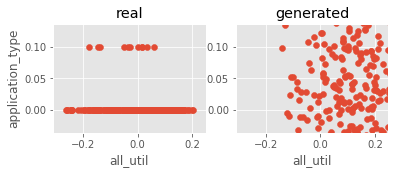

Step: 100 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0058, -0.0082, -0.0002, 0.9933
D Real - D Gen: 0.0080


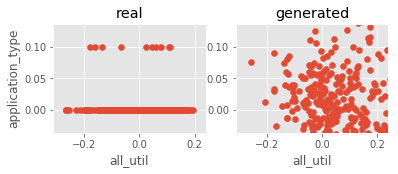

Step: 200 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0002, -0.0018, 0.0035, 0.9866
D Real - D Gen: 0.0053


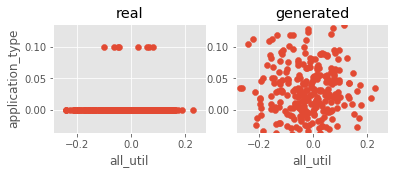

Step: 300 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0055, -0.0105, -0.0024, 0.9933
D Real - D Gen: 0.0081


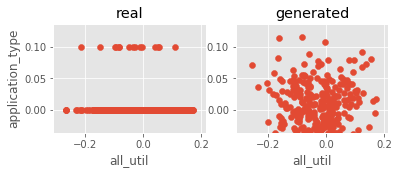

Step: 400 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0109, 0.0099, 0.0162, 0.9966
D Real - D Gen: 0.0063


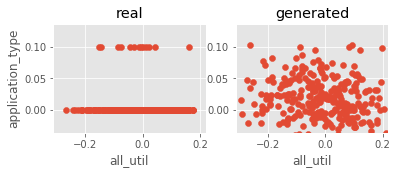

Step: 500 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0139, 0.0110, 0.0185, 1.0000
D Real - D Gen: 0.0075


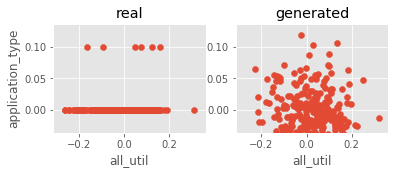

Step: 600 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0016, -0.0043, 0.0029, 0.9966
D Real - D Gen: 0.0072


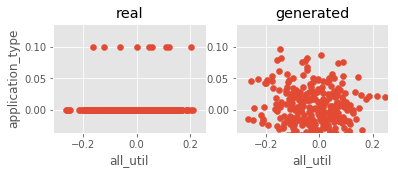

Step: 700 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0088, 0.0051, 0.0118, 0.9966
D Real - D Gen: 0.0067


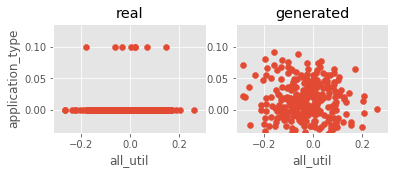

Step: 800 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0080, 0.0051, 0.0112, 1.0000
D Real - D Gen: 0.0061


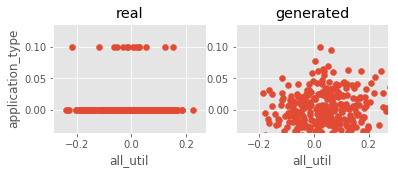

Step: 900 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0200, 0.0180, 0.0230, 0.9966
D Real - D Gen: 0.0050


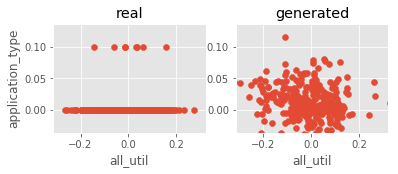

Step: 1000 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0140, 0.0102, 0.0159, 0.9933
D Real - D Gen: 0.0057


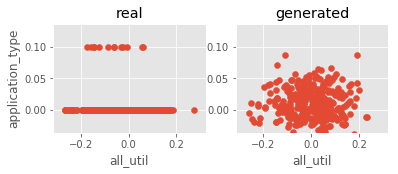

Step: 1100 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0020, 0.0008, 0.0067, 0.9866
D Real - D Gen: 0.0058


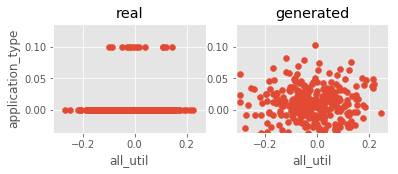

Step: 1200 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0131, 0.0094, 0.0157, 1.0000
D Real - D Gen: 0.0063


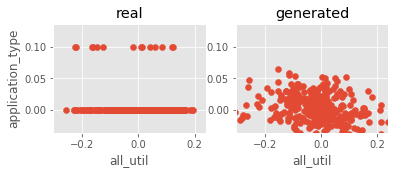

Step: 1300 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0055, 0.0032, 0.0096, 0.9966
D Real - D Gen: 0.0064


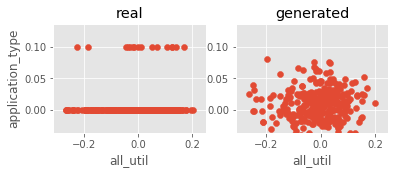

Step: 1400 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0188, 0.0162, 0.0236, 0.9933
D Real - D Gen: 0.0074


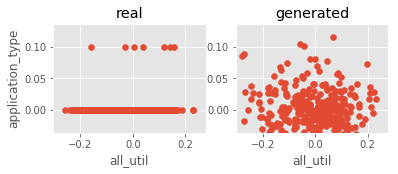

Step: 1500 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0164, 0.0142, 0.0202, 0.9899
D Real - D Gen: 0.0060


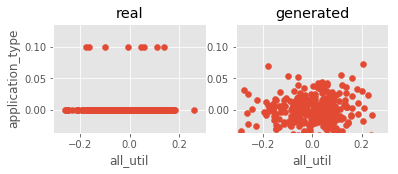

Step: 1600 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0138, 0.0139, 0.0179, 0.9866
D Real - D Gen: 0.0040


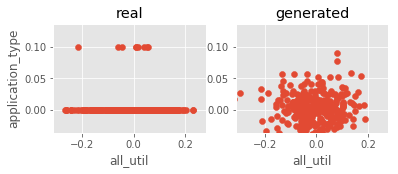

Step: 1700 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0017, 0.0000, 0.0051, 0.9933
D Real - D Gen: 0.0051


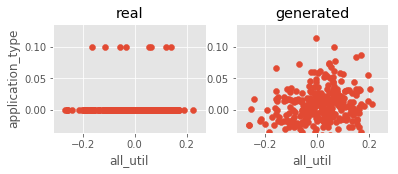

Step: 1800 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0086, -0.0095, -0.0045, 1.0000
D Real - D Gen: 0.0050


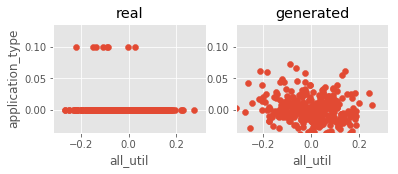

Step: 1900 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0023, -0.0012, 0.0052, 1.0000
D Real - D Gen: 0.0063


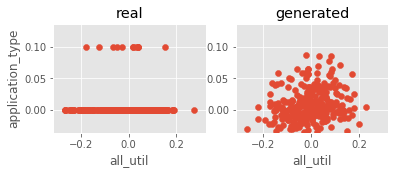

Step: 2000 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0006, -0.0016, 0.0040, 0.9966
D Real - D Gen: 0.0056


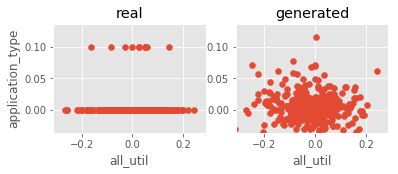

Step: 2100 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0121, 0.0101, 0.0163, 0.9664
D Real - D Gen: 0.0061


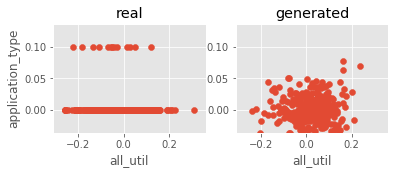

Step: 2200 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0259, 0.0242, 0.0297, 0.9966
D Real - D Gen: 0.0055


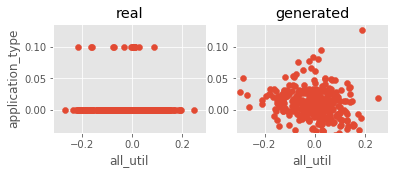

Step: 2300 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0240, 0.0220, 0.0274, 0.9899
D Real - D Gen: 0.0054


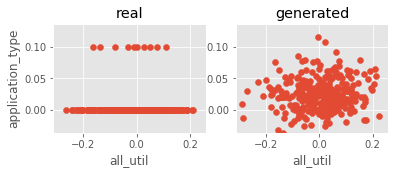

Step: 2400 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0520, 0.0501, 0.0553, 0.9799
D Real - D Gen: 0.0052


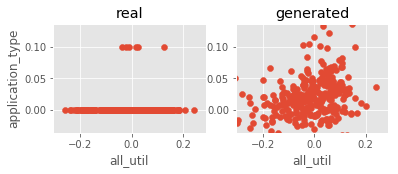

Step: 2500 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0450, 0.0444, 0.0484, 0.9832
D Real - D Gen: 0.0040


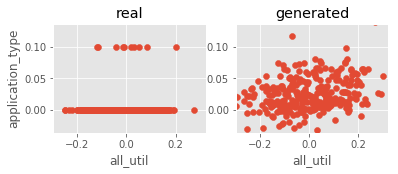

Step: 2600 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0388, 0.0372, 0.0424, 0.9899
D Real - D Gen: 0.0052


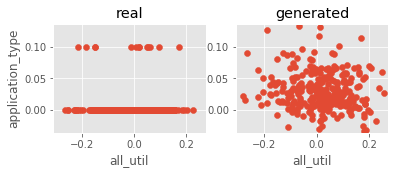

Step: 2700 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0407, 0.0396, 0.0435, 1.0000
D Real - D Gen: 0.0039


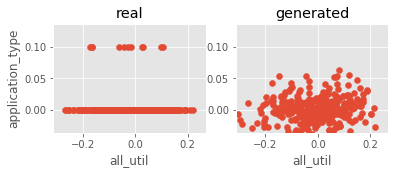

Step: 2800 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0491, 0.0464, 0.0505, 0.9933
D Real - D Gen: 0.0041


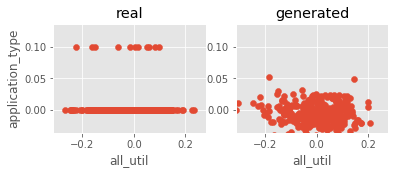

Step: 2900 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0367, 0.0353, 0.0393, 0.9765
D Real - D Gen: 0.0040


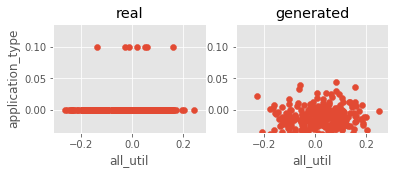

Step: 3000 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0411, 0.0390, 0.0432, 0.9899
D Real - D Gen: 0.0042


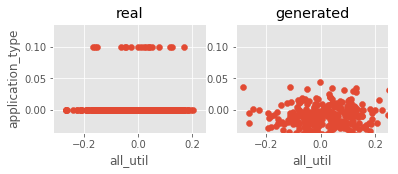

Step: 3100 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0661, 0.0638, 0.0678, 0.9966
D Real - D Gen: 0.0040


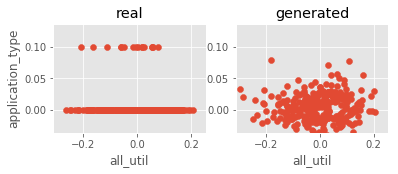

Step: 3200 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0445, 0.0433, 0.0473, 0.9899
D Real - D Gen: 0.0040


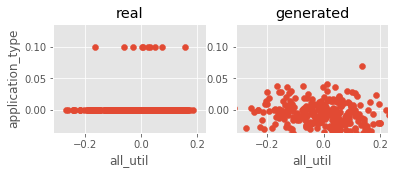

Step: 3300 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0571, 0.0570, 0.0602, 1.0000
D Real - D Gen: 0.0032


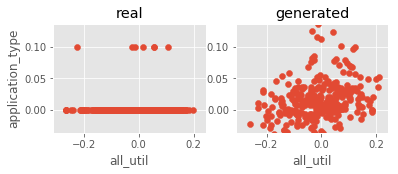

Step: 3400 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0356, 0.0340, 0.0373, 0.9966
D Real - D Gen: 0.0033


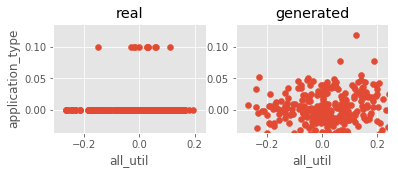

Step: 3500 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0258, 0.0234, 0.0268, 1.0000
D Real - D Gen: 0.0034


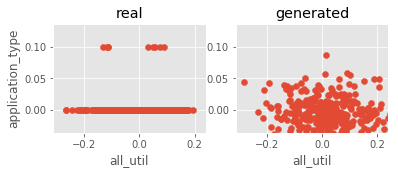

Step: 3600 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0209, 0.0213, 0.0240, 0.9866
D Real - D Gen: 0.0027


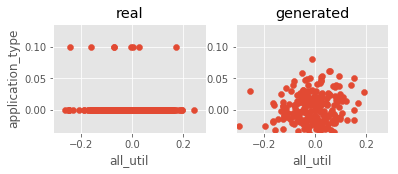

Step: 3700 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0454, 0.0432, 0.0471, 0.9966
D Real - D Gen: 0.0039


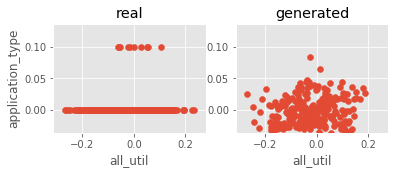

Step: 3800 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0427, 0.0414, 0.0449, 0.9933
D Real - D Gen: 0.0035


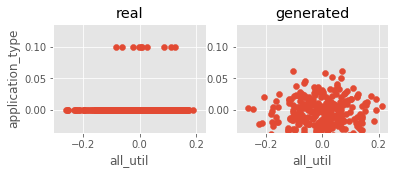

Step: 3900 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0228, 0.0224, 0.0264, 0.9966
D Real - D Gen: 0.0039


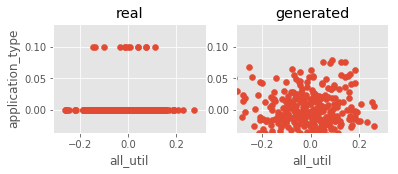

Step: 4000 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0095, 0.0082, 0.0109, 0.9966
D Real - D Gen: 0.0027


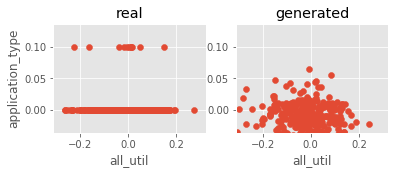

Step: 4100 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0072, -0.0078, -0.0042, 1.0000
D Real - D Gen: 0.0036


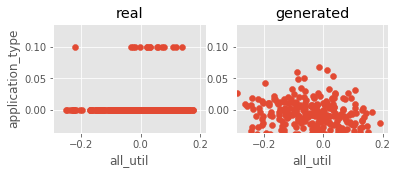

Step: 4200 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0329, 0.0313, 0.0334, 0.9866
D Real - D Gen: 0.0021


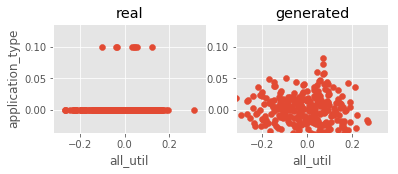

Step: 4300 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0406, 0.0406, 0.0414, 0.9966
D Real - D Gen: 0.0008


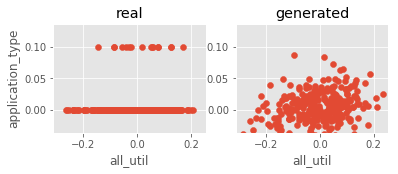

Step: 4400 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0622, 0.0614, 0.0649, 0.9866
D Real - D Gen: 0.0036


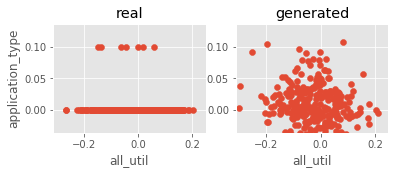

Step: 4500 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0591, 0.0576, 0.0609, 0.9698
D Real - D Gen: 0.0033


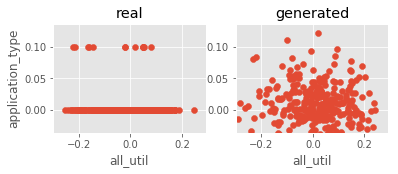

Step: 4600 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0579, 0.0555, 0.0579, 0.9966
D Real - D Gen: 0.0024


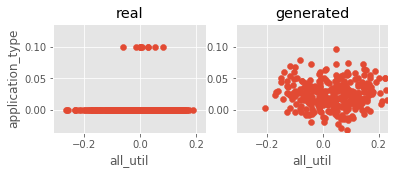

Step: 4700 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0677, 0.0662, 0.0684, 1.0000
D Real - D Gen: 0.0022


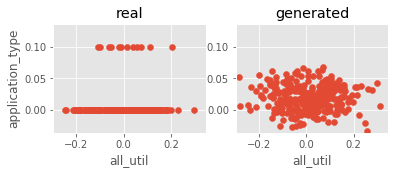

Step: 4800 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0603, 0.0598, 0.0632, 1.0000
D Real - D Gen: 0.0034


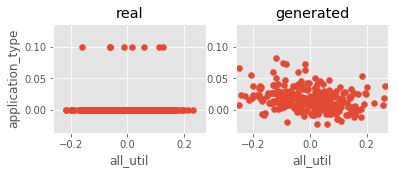

Step: 4900 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0759, 0.0722, 0.0755, 0.9899
D Real - D Gen: 0.0033


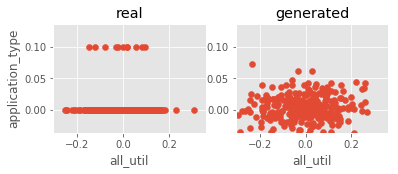

Step: 5000 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0792, 0.0765, 0.0788, 0.9664
D Real - D Gen: 0.0022


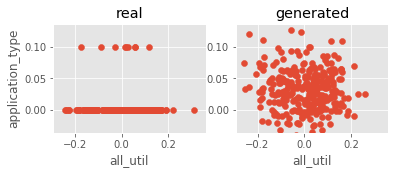

data_dim:  18
data_cols:  ['all_util', 'application_type', 'funded_amnt', 'last_credit_pull_d_month', 'acc_open_past_24mths', 'open_to_total_Acc', 'annual_inc_joint', 'out_prncp', 'sub_grade', 'term', 'delinq_2yrs', 'emp_length', 'home_ownership', 'int_rate', 'total_revol_util', 'interest_ration_to_princi_amt', 'dti_joint', 'total_pymnt']
label_dim:  1
label_cols:  ['Response']
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 18)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenat

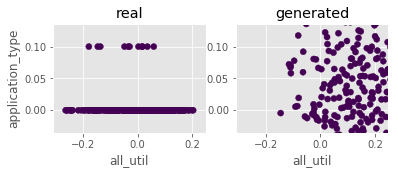

Step: 100 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0591, 0.0577, 0.0629, 1.0000
D Real - D Gen: 0.0052


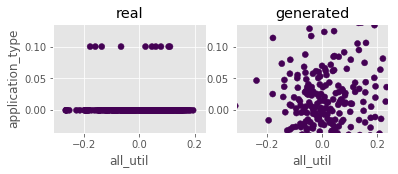

Step: 200 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0399, 0.0386, 0.0430, 0.9866
D Real - D Gen: 0.0044


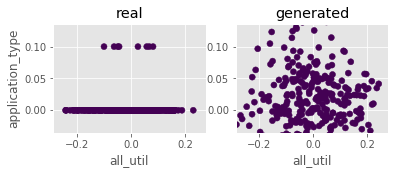

Step: 300 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0249, 0.0256, 0.0303, 0.9966
D Real - D Gen: 0.0047


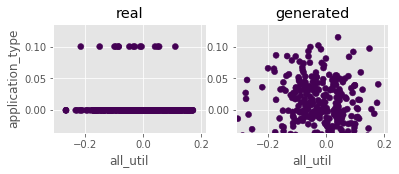

Step: 400 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0414, 0.0387, 0.0439, 1.0000
D Real - D Gen: 0.0052


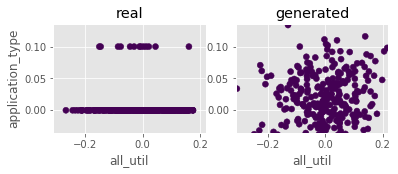

Step: 500 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0536, 0.0535, 0.0575, 1.0000
D Real - D Gen: 0.0041


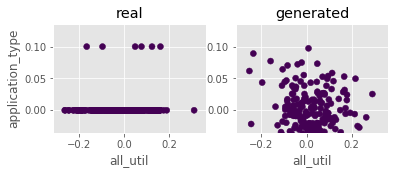

Step: 600 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0828, 0.0785, 0.0826, 0.9933
D Real - D Gen: 0.0041


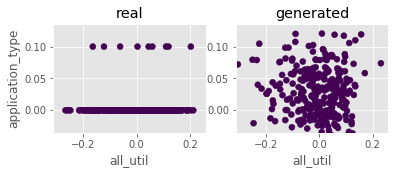

Step: 700 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0421, 0.0431, 0.0485, 0.9765
D Real - D Gen: 0.0053


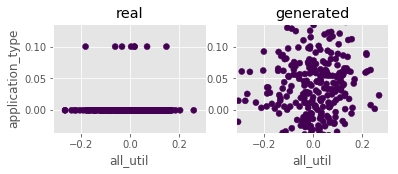

Step: 800 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0293, 0.0287, 0.0326, 0.9933
D Real - D Gen: 0.0039


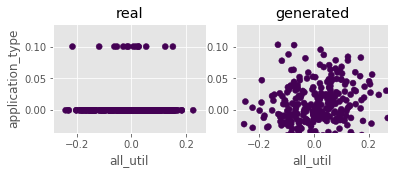

Step: 900 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0296, 0.0280, 0.0322, 0.9966
D Real - D Gen: 0.0042


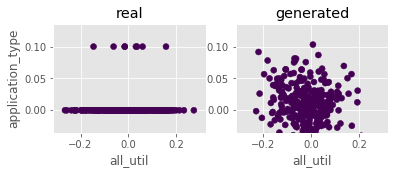

Step: 1000 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0012, -0.0020, 0.0018, 0.9899
D Real - D Gen: 0.0038


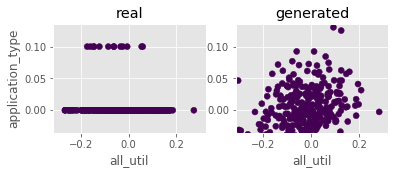

Step: 1100 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0187, 0.0175, 0.0198, 0.9899
D Real - D Gen: 0.0023


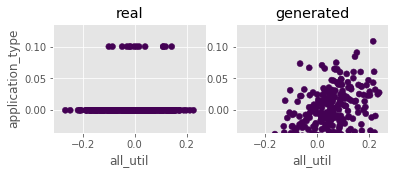

Step: 1200 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0313, 0.0303, 0.0334, 0.9933
D Real - D Gen: 0.0031


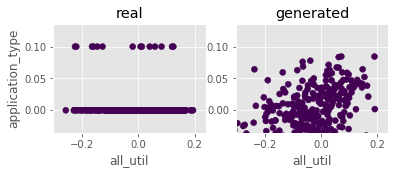

Step: 1300 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0341, 0.0304, 0.0323, 1.0000
D Real - D Gen: 0.0019


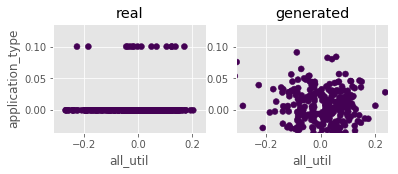

Step: 1400 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0077, 0.0072, 0.0121, 0.9933
D Real - D Gen: 0.0049


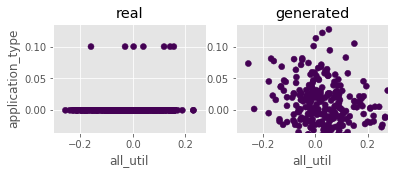

Step: 1500 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0033, -0.0054, -0.0019, 0.9933
D Real - D Gen: 0.0035


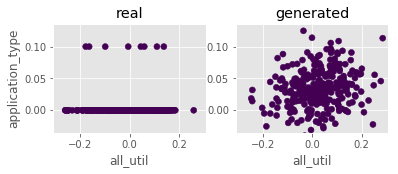

Step: 1600 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0081, -0.0110, -0.0074, 0.9765
D Real - D Gen: 0.0036


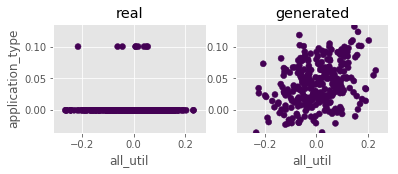

Step: 1700 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0101, 0.0103, 0.0144, 1.0000
D Real - D Gen: 0.0042


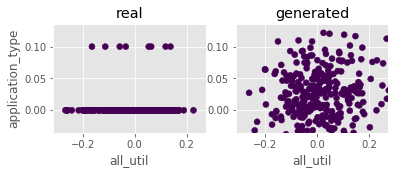

Step: 1800 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0018, 0.0014, 0.0050, 0.9933
D Real - D Gen: 0.0035


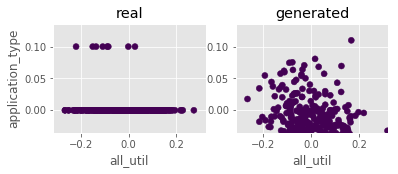

Step: 1900 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0288, 0.0268, 0.0306, 1.0000
D Real - D Gen: 0.0038


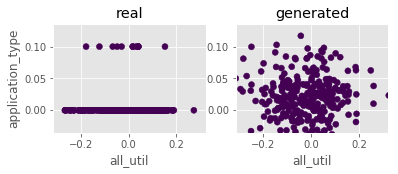

Step: 2000 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0332, 0.0320, 0.0363, 0.9933
D Real - D Gen: 0.0043


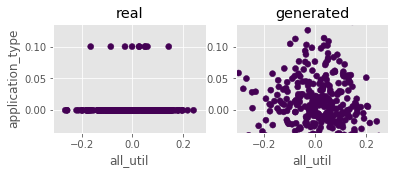

Step: 2100 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0400, 0.0398, 0.0445, 0.9933
D Real - D Gen: 0.0047


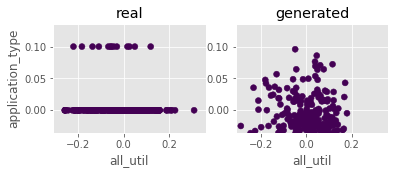

Step: 2200 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0411, 0.0394, 0.0438, 0.9899
D Real - D Gen: 0.0043


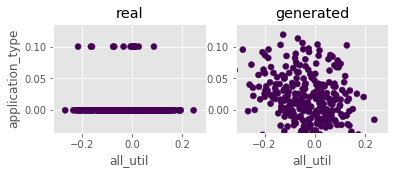

Step: 2300 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0252, 0.0254, 0.0286, 0.9966
D Real - D Gen: 0.0032


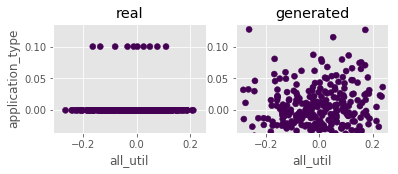

Step: 2400 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0169, -0.0164, -0.0110, 0.9765
D Real - D Gen: 0.0054


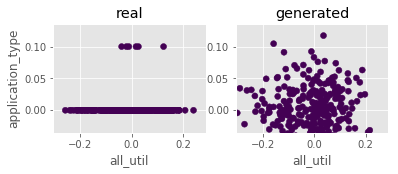

Step: 2500 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0129, -0.0175, -0.0147, 0.9933
D Real - D Gen: 0.0028


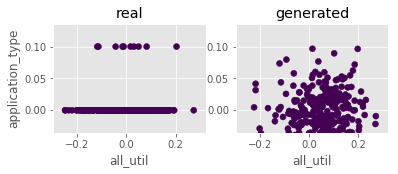

Step: 2600 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0023, -0.0020, 0.0013, 1.0000
D Real - D Gen: 0.0033


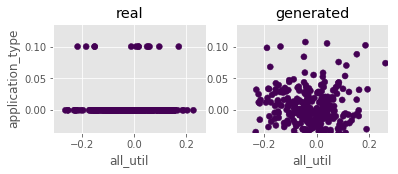

Step: 2700 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0261, 0.0254, 0.0301, 0.9933
D Real - D Gen: 0.0047


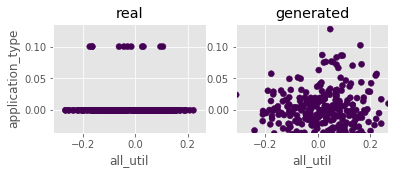

Step: 2800 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0883, 0.0915, 0.0950, 0.9933
D Real - D Gen: 0.0034


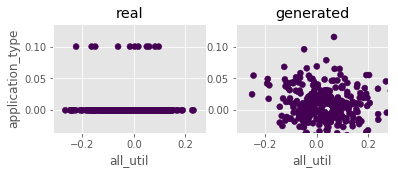

Step: 2900 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0627, 0.0618, 0.0652, 0.9966
D Real - D Gen: 0.0035


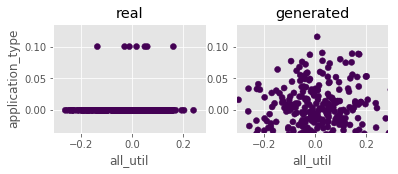

Step: 3000 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0783, 0.0679, 0.0722, 1.0000
D Real - D Gen: 0.0043


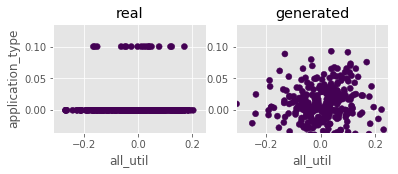

Step: 3100 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0772, 0.0795, 0.0820, 1.0000
D Real - D Gen: 0.0025


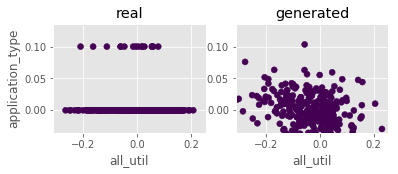

Step: 3200 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.1025, 0.1043, 0.1056, 0.9866
D Real - D Gen: 0.0013


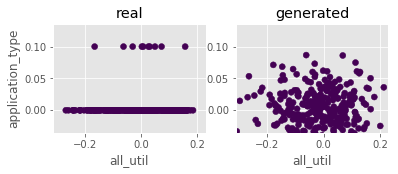

Step: 3300 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0397, 0.0398, 0.0403, 1.0000
D Real - D Gen: 0.0005


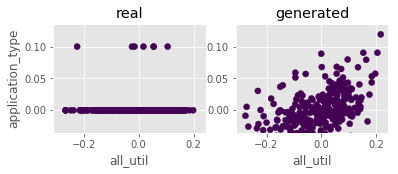

Step: 3400 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0092, 0.0085, 0.0117, 0.9899
D Real - D Gen: 0.0032


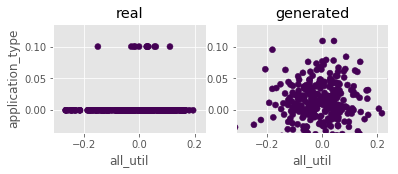

Step: 3500 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0063, 0.0043, 0.0043, 0.9866
D Real - D Gen: -0.0000


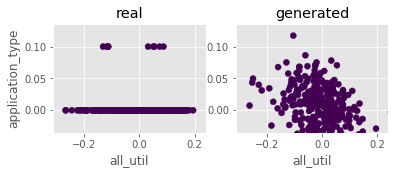

Step: 3600 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0397, 0.0400, 0.0411, 0.9966
D Real - D Gen: 0.0010


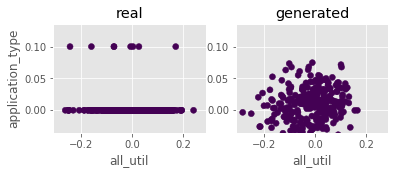

Step: 3700 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0435, 0.0361, 0.0397, 1.0000
D Real - D Gen: 0.0036


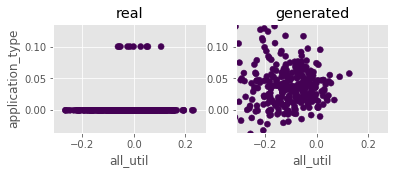

Step: 3800 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.1372, 0.1265, 0.1431, 0.9866
D Real - D Gen: 0.0165


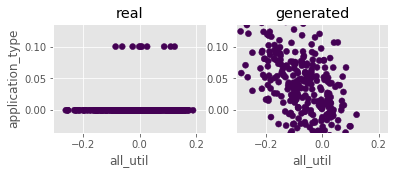

Step: 3900 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0549, 0.0558, 0.0537, 0.9933
D Real - D Gen: -0.0021


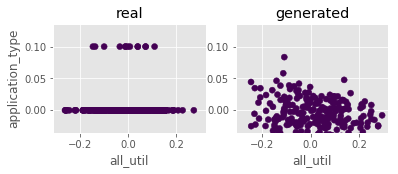

Step: 4000 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0161, 0.0207, 0.0201, 1.0000
D Real - D Gen: -0.0006


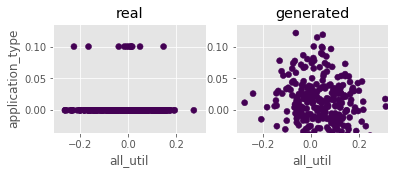

Step: 4100 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0013, -0.0027, 0.0031, 1.0000
D Real - D Gen: 0.0058


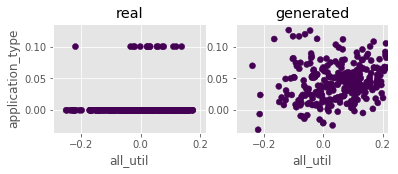

Step: 4200 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0425, -0.0444, -0.0392, 0.9966
D Real - D Gen: 0.0053


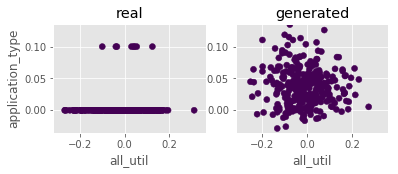

Step: 4300 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0587, 0.0581, 0.0591, 0.9631
D Real - D Gen: 0.0010


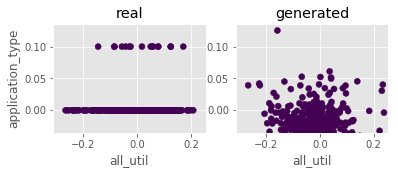

Step: 4400 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.1005, 0.0932, 0.0971, 0.9966
D Real - D Gen: 0.0039


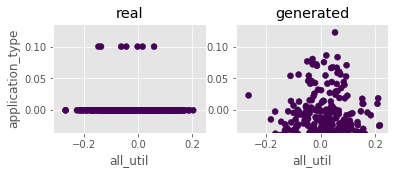

Step: 4500 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.1100, 0.1108, 0.1114, 1.0000
D Real - D Gen: 0.0006


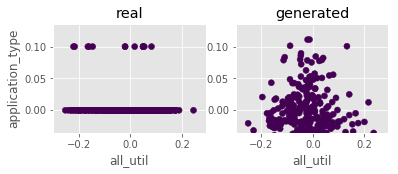

Step: 4600 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.1336, 0.1342, 0.1372, 0.9933
D Real - D Gen: 0.0030


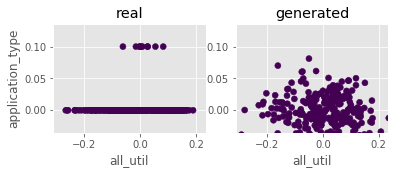

Step: 4700 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.1871, 0.1846, 0.1844, 0.9933
D Real - D Gen: -0.0002


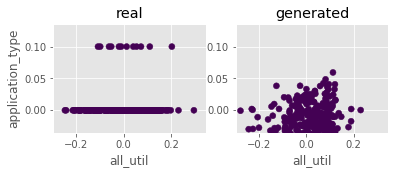

Step: 4800 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0396, 0.0386, 0.0389, 1.0000
D Real - D Gen: 0.0003


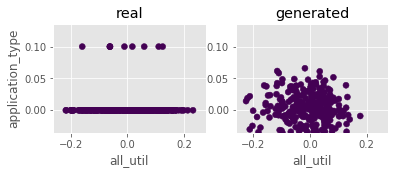

Step: 4900 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0336, 0.0411, 0.0424, 1.0000
D Real - D Gen: 0.0013


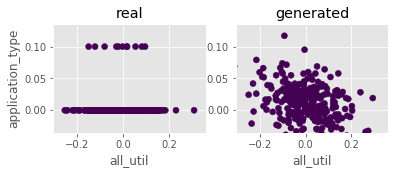

Step: 5000 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0562, 0.0546, 0.0573, 0.9698
D Real - D Gen: 0.0027


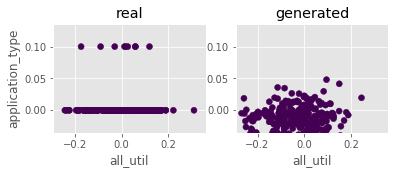

In [6]:
k_d = 5 # train critic to optimal state each time
learning_rate = 1e-4 # 5e-5
arguments = [rand_dim, nb_steps, batch_size, 
             k_d, k_g, critic_pre_train_steps, log_interval, learning_rate, base_n_count,
            data_dir, generator_model_path, discriminator_model_path, loss_pickle_path, show ]

adversarial_training_WGAN(arguments, train_no_label, data_cols=data_cols ) # WGAN
adversarial_training_WGAN(arguments, train, data_cols=data_cols, label_cols=label_cols ) # WCGAN


WGAN  step 3760: 0.9631
WGAN  step 2100: 0.9664

WCGAN step 2760: 0.9530
WCGAN step 4300: 0.9631



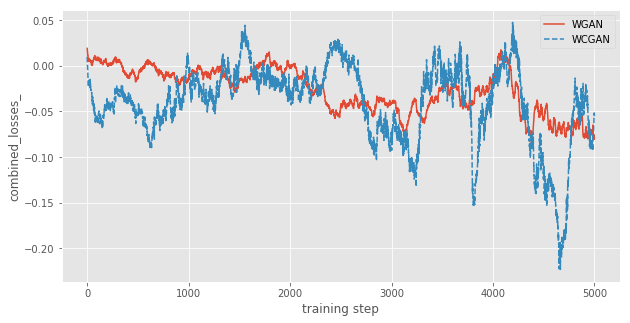

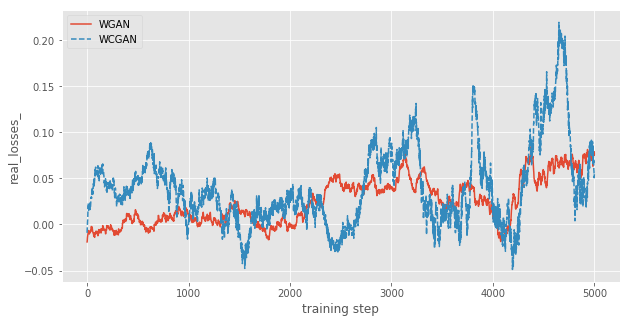

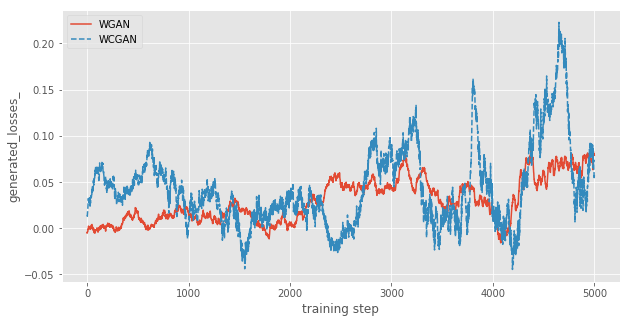

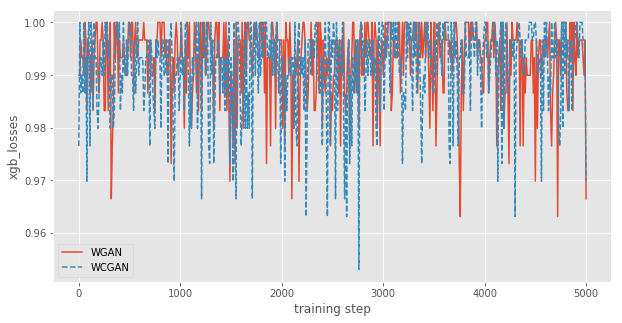

In [7]:
base_dir = 'cache/'

suffix = '_step_5000'

#GAN_losses = pickle.load(open(base_dir +'GAN_losses'+suffix+'.pkl','rb'))
# GAN_losses = [combined_loss, disc_loss_real, disc_loss_generated, xgb_losses]

#CGAN_losses = pickle.load(open(base_dir + 'CGAN_losses'+suffix+'.pkl','rb'))
WGAN_losses = pickle.load(open(base_dir + 'WGAN_losses'+suffix+'.pkl','rb'))
WCGAN_losses = pickle.load(open(base_dir + 'WCGAN_losses'+suffix+'.pkl','rb'))
data_ix = 3
data_sets = [ WGAN_losses[data_ix], WCGAN_losses[data_ix]]
labels = [ 'WGAN','WCGAN' ]

for label, data_set in zip( labels, data_sets ):
    best_step = list(data_set).index( np.array(data_set).min() ) * 10
    print( '{: <5} step {: <4}: {:.4f}'.format( label, best_step, np.array(data_set).min() ) )

    xgb100 = [ data_set[i] for i in range(0, len(data_set), 10) ]
    best_step = xgb100.index( min(xgb100) ) * 100
    print( '{: <5} step {: <4}: {:.4f}\n'.format( label, best_step, np.array(xgb100).min() ) )
#     print( best_step, min(xgb100) )

data_fields = ['combined_losses_', 'real_losses_', 'generated_losses_', 'xgb_losses']
sampling_intervals = [ 1, 1, 1, 10 ]
labels = ['WGAN','WCGAN' ]
linestyles = ['-', '--', '-.', ':']

for data_ix in range(len(data_fields)):
    data_sets = [  WGAN_losses[data_ix], WCGAN_losses[data_ix]]

    plt.figure(figsize=(10,5))
    for data, label, linestyle in zip(data_sets, labels, linestyles):
        plt.plot( np.array(range(0,len(data)))*sampling_intervals[data_ix],
                 data,
                 label=label, linestyle=linestyle )

    plt.ylabel(data_fields[data_ix])
    plt.xlabel('training step')
    plt.legend()
    plt.show()